In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def create_circle_pattern(matrix, row, col, radius):
    n = matrix.shape[0]
    x, y = np.ogrid[:n, :n]
    dist = np.sqrt((x-row)**2 + (y-col)**2)
    matrix[dist <= radius] = 1
    return matrix

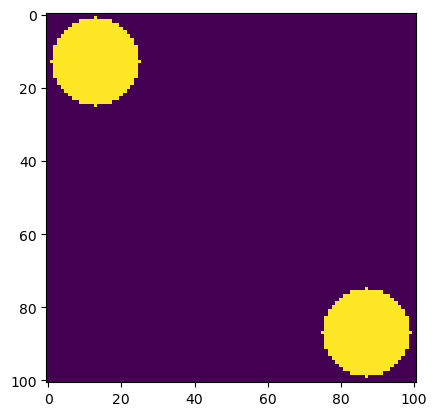

In [7]:
# Constants
M = 100         # Grid squares on a side

freq = 100e6    # Drive frequency
Omega_Rf = 2 * np.pi *freq
A = 5           # Electric field amplitude
rod_radius = 12

coords_pos = [[rod_radius+1,rod_radius+1],[M-rod_radius-1,M-rod_radius-1]]
coords_neg = [[M-rod_radius-1,rod_radius+1],[rod_radius+1,M-rod_radius-1]]
pos_bit_pattern = np.zeros([M+1,M+1])
neg_bit_pattern = np.zeros([M+1,M+1])
for row,col in coords_pos:
    pos_bit_pattern = create_circle_pattern(pos_bit_pattern,row,col,rod_radius)
for row,col in coords_neg:
    neg_bit_pattern = create_circle_pattern(neg_bit_pattern,row,col,rod_radius)



In [ ]:
L = 10.0     # Side length of box [m]
target = 1e-6   # Target accuracy [1uV]
epsilon_0 = 8.85e-12

a = L / float(M) # grid point spacing

# Create arrays to hold potential values, including capacitor vals
phi = np.zeros([M+1,M+1], float)
rho = np.zeros([M+1,M+1], float)
rho[int(xp/a):int((xp+l)/a),int(xp/a)] = Vp
rho[int(xp/a):int((xp+l)/a),int(xn/a)] = Vn

phi[int(xp/a):int((xp+l)/a),int(xp/a)] = Vp
phi[int(xp/a):int((xp+l)/a),int(xn/a)] = Vn

phiprime = np.zeros([M+1,M+1],float)

# Main loop
delta = 1.0
iteration = 0
while delta>target:
    # Calculate new values of the potential
    phiprime[0,:] = phi[0,:]
    phiprime[-1,:] = phi[-1,:]
    phiprime[:,0] = phi[:,0]
    phiprime[:,-1] = phi[:,-1]


    phiprime[1:M,1:M] = 0.25 * (phi[2:,1:M] + phi[:M-1,1:M] + phi[1:M,2:] + phi[1:M,:M-1]) + \
        (0.25 * a**2 / epsilon_0) * rho[1:M,1:M]    
                                      
    # Calculate maximum fractional difference from old values
    delta = np.abs(phi-phiprime)
    nonzero = phi > 0
    if nonzero.any():

        delta = np.max(delta[nonzero])
    else:
        delta = 1.0
    if iteration % 10 == 0:
        print("Iteration %3d: max. residual = %12.6g" % (iteration, delta))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi
    iteration += 1
# Make a plot
plt.imshow(phi)
plt.gray()
plt.show()